In [1]:
from time import time
import xarray as xr
import boto3
import os

In [2]:
def _split_full_path(bucket_full_path):
    if 's3://' in bucket_full_path:
        bucket_full_path=bucket_full_path.replace('s3://','') 
    print(bucket_full_path)
    bucket = bucket_full_path.split('/')[0]
    bucket_filepath = '/'.join(bucket_full_path.split('/')[1:])
    return (bucket, bucket_filepath)

In [3]:
def s3_push_delete_local(local_file, bucket_full_path):
        s3 = boto3.client('s3')
        with open(local_file, "rb") as f:
            (bucket, bucket_filepath) = _split_full_path(bucket_full_path)
            s3.upload_fileobj(f, bucket, bucket_filepath)
        os.remove(local_file)

In [4]:
def write_GeoTif_like(templet_tif_file, output_ndarry, output_tif_file):
    import rasterio
    orig = rasterio.open(templet_tif_file)
    print('write file ', output_tif_file)
    with rasterio.open(output_tif_file, 'w', driver='GTiff', height=output_ndarry.shape[0],
                       width=output_ndarry.shape[1], count=1, dtype=output_ndarry.dtype,
                       crs=orig.crs, transform=orig.transform, nodata=-9999) as dst:
        dst.write(output_ndarry, 1)

In [5]:

def _get_year_month(product, tif):
    fn = tif.split('/')[-1]
    fn = fn.replace(product,'')
    fn = fn.replace('.tif','')
    print(fn)
    fn=fn[-3:]
    return fn

In [6]:

def xr_build_cube_concat_ds(tif_list, product):

    start = time()
    my_da_list =[]
    year_month_list = []
    for tif in tif_list:
        tiffile = tif
        #print(tiffile)
        da = xr.open_rasterio(tiffile)
        my_da_list.append(da)
        tnow = time()
        elapsed = tnow - start
        #print(tif, elapsed)
        print('.',flush=True)
        year_month_list.append(_get_year_month(product, tif))

    da = xr.concat(my_da_list, dim='band')
    da = da.rename({'band':'day'})
    da = da.assign_coords(day=year_month_list)
    DS = da.to_dataset(name=product)
    return(DS)

In [7]:
! aws s3 ls dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/


2020-10-01 07:10:48      35692 Tasavg_1950001.tif
2020-10-01 07:10:49      35692 Tasavg_1950002.tif
2020-10-01 07:10:50      35692 Tasavg_1950003.tif
2020-10-01 07:10:51      35692 Tasavg_1950004.tif
2020-10-01 07:10:52      35692 Tasavg_1950005.tif
2020-10-01 07:10:53      35692 Tasavg_1950006.tif
2020-10-01 07:10:54      35692 Tasavg_1950007.tif
2020-10-01 07:10:54      35692 Tasavg_1950008.tif
2020-10-01 07:10:55      35692 Tasavg_1950009.tif
2020-10-01 07:10:56      35692 Tasavg_1950010.tif
2020-10-01 07:10:57      35692 Tasavg_1950011.tif
2020-10-01 07:10:58      35692 Tasavg_1950012.tif
2020-10-01 07:10:59      35692 Tasavg_1950013.tif
2020-10-01 07:10:59      35692 Tasavg_1950014.tif
2020-10-01 07:11:00      35692 Tasavg_1950015.tif
2020-10-01 07:11:01      35692 Tasavg_1950016.tif
2020-10-01 07:11:02      35692 Tasavg_1950017.tif
2020-10-01 07:11:03      35692 Tasavg_1950018.tif
2020-10-01 07:11:04      35692 Tasavg_1950019.tif
2020-10-01 07:11:05      35692 Tasavg_1950020.tif


2020-10-01 07:14:46      35692 Tasavg_1950277.tif
2020-10-01 07:14:47      35692 Tasavg_1950278.tif
2020-10-01 07:14:47      35692 Tasavg_1950279.tif
2020-10-01 07:14:48      35692 Tasavg_1950280.tif
2020-10-01 07:14:49      35692 Tasavg_1950281.tif
2020-10-01 07:14:50      35692 Tasavg_1950282.tif
2020-10-01 07:14:51      35692 Tasavg_1950283.tif
2020-10-01 07:14:52      35692 Tasavg_1950284.tif
2020-10-01 07:14:54      35692 Tasavg_1950285.tif
2020-10-01 07:14:55      35692 Tasavg_1950286.tif
2020-10-01 07:14:55      35692 Tasavg_1950287.tif
2020-10-01 07:14:56      35692 Tasavg_1950288.tif
2020-10-01 07:14:57      35692 Tasavg_1950289.tif
2020-10-01 07:14:58      35692 Tasavg_1950290.tif
2020-10-01 07:14:59      35692 Tasavg_1950291.tif
2020-10-01 07:15:00      35692 Tasavg_1950292.tif
2020-10-01 07:15:01      35692 Tasavg_1950293.tif
2020-10-01 07:15:01      35692 Tasavg_1950294.tif
2020-10-01 07:15:03      35692 Tasavg_1950295.tif
2020-10-01 07:15:04      35692 Tasavg_1950296.tif


In [8]:

def create_s3_list_of_days(main_prefix, year, temperatureType):
    output_name = f'{temperatureType}_'
    the_list = []
    for i in range(1,366):
        day = f'{i:03d}'
        file_object = main_prefix + temperatureType + '/' + str(year) +  '/' + output_name + str(year) + day + '.tif'
        the_list.append(file_object)
    return the_list



In [9]:
main_bucket_prefix='s3://dev-et-data/in/DelawareRiverBasin/Temp/'
year='1950'
temperatureType = 'Tasavg'


In [10]:
tif_list = create_s3_list_of_days(main_bucket_prefix, year, temperatureType)

In [11]:
tif_list

['s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950001.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950002.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950003.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950004.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950005.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950006.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950007.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950008.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950009.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950010.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950011.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950012.tif',
 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg

In [12]:
#tif_list_pruned = tif_list[0:364:30]

In [13]:
ds = xr_build_cube_concat_ds(tif_list, temperatureType)
#ds = xr_build_cube_concat_ds(tif_list_pruned, temperatureType)

.
_1950001
.
_1950002
.
_1950003
.
_1950004
.
_1950005
.
_1950006
.
_1950007
.
_1950008
.
_1950009
.
_1950010
.
_1950011
.
_1950012
.
_1950013
.
_1950014
.
_1950015
.
_1950016
.
_1950017
.
_1950018
.
_1950019
.
_1950020
.
_1950021
.
_1950022
.
_1950023
.
_1950024
.
_1950025
.
_1950026
.
_1950027
.
_1950028
.
_1950029
.
_1950030
.
_1950031
.
_1950032
.
_1950033
.
_1950034
.
_1950035
.
_1950036
.
_1950037
.
_1950038
.
_1950039
.
_1950040
.
_1950041
.
_1950042
.
_1950043
.
_1950044
.
_1950045
.
_1950046
.
_1950047
.
_1950048
.
_1950049
.
_1950050
.
_1950051
.
_1950052
.
_1950053
.
_1950054
.
_1950055
.
_1950056
.
_1950057
.
_1950058
.
_1950059
.
_1950060
.
_1950061
.
_1950062
.
_1950063
.
_1950064
.
_1950065
.
_1950066
.
_1950067
.
_1950068
.
_1950069
.
_1950070
.
_1950071
.
_1950072
.
_1950073
.
_1950074
.
_1950075
.
_1950076
.
_1950077
.
_1950078
.
_1950079
.
_1950080
.
_1950081
.
_1950082
.
_1950083
.
_1950084
.
_1950085
.
_1950086
.
_1950087
.
_1950088
.
_1950089
.
_1950090
.
_1950091

In [14]:
#! aws s3 ls s3://dev-et-data/enduser/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950001.tif

In [15]:
#! aws s3 ls s3://dev-et-data/enduser/DelawareRiverBasin/Temp/

In [16]:
ds

<xarray.Dataset>
Dimensions:  (day: 365, x: 74, y: 119)
Coordinates:
  * day      (day) <U3 '001' '002' '003' '004' '005' ... '362' '363' '364' '365'
  * y        (y) float64 38.1 38.15 38.19 38.23 38.27 ... 42.9 42.94 42.98 43.02
  * x        (x) float64 -76.77 -76.73 -76.69 -76.65 ... -73.81 -73.77 -73.73
Data variables:
    Tasavg   (day, y, x) float32 284.87338 284.39362 ... 274.87054 274.99933

In [17]:
dstk=ds.sel(x=-75,y=41, method='nearest')

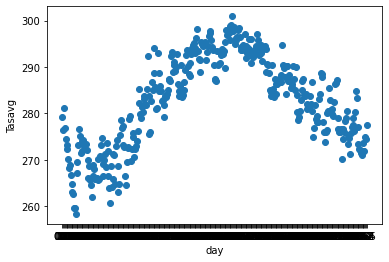

In [18]:
dstk.plot.scatter(x='day', y='Tasavg')

In [19]:
ds.dims

Frozen(SortedKeysDict({'day': 365, 'y': 119, 'x': 74}))

In [20]:
for i in range(0,ds.dims['day']):
    print(ds['Tasavg'][i]['day'])

<xarray.DataArray 'day' ()>
array('001', dtype='<U3')
Coordinates:
    day      <U3 '001'
<xarray.DataArray 'day' ()>
array('002', dtype='<U3')
Coordinates:
    day      <U3 '002'
<xarray.DataArray 'day' ()>
array('003', dtype='<U3')
Coordinates:
    day      <U3 '003'
<xarray.DataArray 'day' ()>
array('004', dtype='<U3')
Coordinates:
    day      <U3 '004'
<xarray.DataArray 'day' ()>
array('005', dtype='<U3')
Coordinates:
    day      <U3 '005'
<xarray.DataArray 'day' ()>
array('006', dtype='<U3')
Coordinates:
    day      <U3 '006'
<xarray.DataArray 'day' ()>
array('007', dtype='<U3')
Coordinates:
    day      <U3 '007'
<xarray.DataArray 'day' ()>
array('008', dtype='<U3')
Coordinates:
    day      <U3 '008'
<xarray.DataArray 'day' ()>
array('009', dtype='<U3')
Coordinates:
    day      <U3 '009'
<xarray.DataArray 'day' ()>
array('010', dtype='<U3')
Coordinates:
    day      <U3 '010'
<xarray.DataArray 'day' ()>
array('011', dtype='<U3')
Coordinates:
    day      <U3 '011'
<xarray.Da

<xarray.DataArray 'day' ()>
array('296', dtype='<U3')
Coordinates:
    day      <U3 '296'
<xarray.DataArray 'day' ()>
array('297', dtype='<U3')
Coordinates:
    day      <U3 '297'
<xarray.DataArray 'day' ()>
array('298', dtype='<U3')
Coordinates:
    day      <U3 '298'
<xarray.DataArray 'day' ()>
array('299', dtype='<U3')
Coordinates:
    day      <U3 '299'
<xarray.DataArray 'day' ()>
array('300', dtype='<U3')
Coordinates:
    day      <U3 '300'
<xarray.DataArray 'day' ()>
array('301', dtype='<U3')
Coordinates:
    day      <U3 '301'
<xarray.DataArray 'day' ()>
array('302', dtype='<U3')
Coordinates:
    day      <U3 '302'
<xarray.DataArray 'day' ()>
array('303', dtype='<U3')
Coordinates:
    day      <U3 '303'
<xarray.DataArray 'day' ()>
array('304', dtype='<U3')
Coordinates:
    day      <U3 '304'
<xarray.DataArray 'day' ()>
array('305', dtype='<U3')
Coordinates:
    day      <U3 '305'
<xarray.DataArray 'day' ()>
array('306', dtype='<U3')
Coordinates:
    day      <U3 '306'
<xarray.Da

In [21]:
ds = ds - 273.15 # convert data array xarray.DataSet from Kelvin to Celsius

In [22]:
ds

<xarray.Dataset>
Dimensions:  (day: 365, x: 74, y: 119)
Coordinates:
  * day      (day) <U3 '001' '002' '003' '004' '005' ... '362' '363' '364' '365'
  * y        (y) float64 38.1 38.15 38.19 38.23 38.27 ... 42.9 42.94 42.98 43.02
  * x        (x) float64 -76.77 -76.73 -76.69 -76.65 ... -73.81 -73.77 -73.73
Data variables:
    Tasavg   (day, y, x) float32 11.723389 11.243622 ... 1.7205505 1.8493347

In [23]:
dst=ds.sel(x=-75,y=41, method='nearest')

In [24]:
dst

<xarray.Dataset>
Dimensions:  (day: 365)
Coordinates:
  * day      (day) <U3 '001' '002' '003' '004' '005' ... '362' '363' '364' '365'
    y        float64 40.98
    x        float64 -74.98
Data variables:
    Tasavg   (day) float32 6.1457214 3.224762 7.9567566 ... 1.2801819 4.4414062

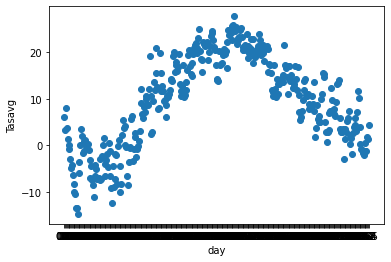

In [25]:
dst.plot.scatter(x='day', y='Tasavg')

In [26]:
dst10=dst.isel(day=slice(0,365,10))

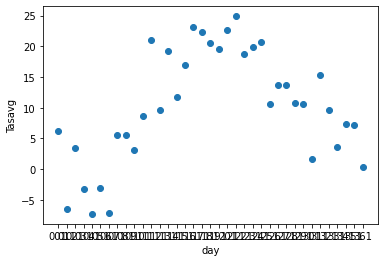

In [27]:
dst10.plot.scatter(x='day', y='Tasavg')

In [28]:
dst30=dst.isel(day=slice(0,365,30))

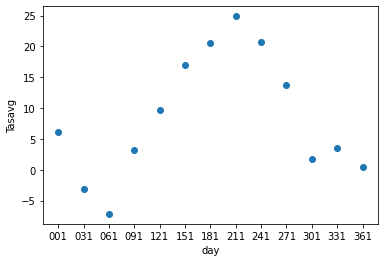

In [29]:
dst30.plot.scatter(x='day', y='Tasavg')

In [30]:
output_main_prefix='s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/'
year='1950'


In [31]:
!mkdir -p ./tmp

In [32]:
import rioxarray
import rasterio
def write_out_celsius_tifs(main_prefix, ds, year, output_name):
    num_days=ds.dims['day']
    for i in range(0,(num_days - 1)):
        dayi = i+1
        day="{:03d}".format(dayi)
        s3_file_object = main_prefix + temperatureType + '/' + str(year) +  '/' + output_name + '_' + str(year) + day + '.tif'
        file_object = './tmp/' + output_name + '_' + str(year) + day + '.tif'

        print(file_object)
        
        np_array = ds[output_name].isel(day=dayi).values
#         print(type(np_array))
        my_template = 's3://dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950017.tif'
        write_GeoTif_like(my_template, np_array, file_object)
        s3_push_delete_local(file_object, s3_file_object)

In [33]:
write_out_celsius_tifs(output_main_prefix, ds, year, 'Tasavg')

./tmp/Tasavg_1950001.tif
write file  ./tmp/Tasavg_1950001.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950001.tif
./tmp/Tasavg_1950002.tif
write file  ./tmp/Tasavg_1950002.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950002.tif
./tmp/Tasavg_1950003.tif
write file  ./tmp/Tasavg_1950003.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950003.tif
./tmp/Tasavg_1950004.tif
write file  ./tmp/Tasavg_1950004.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950004.tif
./tmp/Tasavg_1950005.tif
write file  ./tmp/Tasavg_1950005.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950005.tif
./tmp/Tasavg_1950006.tif
write file  ./tmp/Tasavg_1950006.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950006.tif
./tmp/Tasavg_1950007.tif
write file  ./tmp/Tasavg_1950007.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950007.tif
./tmp/Tasavg_1950008.tif
wr

write file  ./tmp/Tasavg_1950060.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950060.tif
./tmp/Tasavg_1950061.tif
write file  ./tmp/Tasavg_1950061.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950061.tif
./tmp/Tasavg_1950062.tif
write file  ./tmp/Tasavg_1950062.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950062.tif
./tmp/Tasavg_1950063.tif
write file  ./tmp/Tasavg_1950063.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950063.tif
./tmp/Tasavg_1950064.tif
write file  ./tmp/Tasavg_1950064.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950064.tif
./tmp/Tasavg_1950065.tif
write file  ./tmp/Tasavg_1950065.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950065.tif
./tmp/Tasavg_1950066.tif
write file  ./tmp/Tasavg_1950066.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950066.tif
./tmp/Tasavg_1950067.tif
write file  ./tmp/Tasavg_19

write file  ./tmp/Tasavg_1950119.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950119.tif
./tmp/Tasavg_1950120.tif
write file  ./tmp/Tasavg_1950120.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950120.tif
./tmp/Tasavg_1950121.tif
write file  ./tmp/Tasavg_1950121.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950121.tif
./tmp/Tasavg_1950122.tif
write file  ./tmp/Tasavg_1950122.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950122.tif
./tmp/Tasavg_1950123.tif
write file  ./tmp/Tasavg_1950123.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950123.tif
./tmp/Tasavg_1950124.tif
write file  ./tmp/Tasavg_1950124.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950124.tif
./tmp/Tasavg_1950125.tif
write file  ./tmp/Tasavg_1950125.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950125.tif
./tmp/Tasavg_1950126.tif
write file  ./tmp/Tasavg_19

write file  ./tmp/Tasavg_1950178.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950178.tif
./tmp/Tasavg_1950179.tif
write file  ./tmp/Tasavg_1950179.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950179.tif
./tmp/Tasavg_1950180.tif
write file  ./tmp/Tasavg_1950180.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950180.tif
./tmp/Tasavg_1950181.tif
write file  ./tmp/Tasavg_1950181.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950181.tif
./tmp/Tasavg_1950182.tif
write file  ./tmp/Tasavg_1950182.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950182.tif
./tmp/Tasavg_1950183.tif
write file  ./tmp/Tasavg_1950183.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950183.tif
./tmp/Tasavg_1950184.tif
write file  ./tmp/Tasavg_1950184.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950184.tif
./tmp/Tasavg_1950185.tif
write file  ./tmp/Tasavg_19

./tmp/Tasavg_1950238.tif
write file  ./tmp/Tasavg_1950238.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950238.tif
./tmp/Tasavg_1950239.tif
write file  ./tmp/Tasavg_1950239.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950239.tif
./tmp/Tasavg_1950240.tif
write file  ./tmp/Tasavg_1950240.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950240.tif
./tmp/Tasavg_1950241.tif
write file  ./tmp/Tasavg_1950241.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950241.tif
./tmp/Tasavg_1950242.tif
write file  ./tmp/Tasavg_1950242.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950242.tif
./tmp/Tasavg_1950243.tif
write file  ./tmp/Tasavg_1950243.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950243.tif
./tmp/Tasavg_1950244.tif
write file  ./tmp/Tasavg_1950244.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950244.tif
./tmp/Tasavg_1950245.tif
wr

./tmp/Tasavg_1950298.tif
write file  ./tmp/Tasavg_1950298.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950298.tif
./tmp/Tasavg_1950299.tif
write file  ./tmp/Tasavg_1950299.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950299.tif
./tmp/Tasavg_1950300.tif
write file  ./tmp/Tasavg_1950300.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950300.tif
./tmp/Tasavg_1950301.tif
write file  ./tmp/Tasavg_1950301.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950301.tif
./tmp/Tasavg_1950302.tif
write file  ./tmp/Tasavg_1950302.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950302.tif
./tmp/Tasavg_1950303.tif
write file  ./tmp/Tasavg_1950303.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950303.tif
./tmp/Tasavg_1950304.tif
write file  ./tmp/Tasavg_1950304.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950304.tif
./tmp/Tasavg_1950305.tif
wr

write file  ./tmp/Tasavg_1950357.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950357.tif
./tmp/Tasavg_1950358.tif
write file  ./tmp/Tasavg_1950358.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950358.tif
./tmp/Tasavg_1950359.tif
write file  ./tmp/Tasavg_1950359.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950359.tif
./tmp/Tasavg_1950360.tif
write file  ./tmp/Tasavg_1950360.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950360.tif
./tmp/Tasavg_1950361.tif
write file  ./tmp/Tasavg_1950361.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950361.tif
./tmp/Tasavg_1950362.tif
write file  ./tmp/Tasavg_1950362.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950362.tif
./tmp/Tasavg_1950363.tif
write file  ./tmp/Tasavg_1950363.tif
dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950363.tif
./tmp/Tasavg_1950364.tif
write file  ./tmp/Tasavg_19

In [34]:
! aws s3 ls s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950012.tif

2021-03-09 18:02:22      35692 Tasavg_1950012.tif


In [35]:
! aws s3 ls s3://dev-et-data/in/DelawareRiverBasin/T

                           PRE Temp/
                           PRE TempCelsius/


In [36]:
!ls tmp

In [37]:
! gdalinfo /vsis3/dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950002.tif

Driver: GTiff/GeoTIFF
Files: /vsis3/dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasavg/1950/Tasavg_1950002.tif
Size is 74, 119
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-76.793782273383997,38.083704964589266)
Pixel Size = (0.041666109267979,0.041665998555846)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -76.7937823,  38.0837050) ( 76d47'37.62"W, 38d 5' 1.34"N)
Lower Left  ( -76.7937823,  43.0419588) ( 76d47'37.62"W, 43d 2'31.05"N)
Upper Right ( -73.7104902,  38.0837050) ( 73d42'37.76"W, 38d 5' 1.34"N)
Lower Right ( -73.7104902,  43.0419588) ( 73d42'37.76"W, 43d 2'31.05"N)
Center      ( -75.2521362,  40.5628319) ( 75d15' 7.69"W, 40d33'46.19"N)
Band 1 Block=74x27 Type=Float32, Co

In [38]:
 !gdalinfo /vsis3/dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950014.tif

Driver: GTiff/GeoTIFF
Files: /vsis3/dev-et-data/in/DelawareRiverBasin/Temp/Tasavg/1950/Tasavg_1950014.tif
Size is 74, 119
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (-76.793782273383997,38.083704964589266)
Pixel Size = (0.041666109267979,0.041665998555846)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -76.7937823,  38.0837050) ( 76d47'37.62"W, 38d 5' 1.34"N)
Lower Left  ( -76.7937823,  43.0419588) ( 76d47'37.62"W, 43d 2'31.05"N)
Upper Right ( -73.7104902,  38.0837050) ( 73d42'37.76"W, 38d 5' 1.34"N)
Lower Right ( -73.7104902,  43.0419588) ( 73d42'37.76"W, 43d 2'31.05"N)
Center      ( -75.2521362,  40.5628319) ( 75d15' 7.69"W, 40d33'46.19"N)
Band 1 Block=74x27 Type=Float32, ColorInte

In [39]:
#!rm ./tmp/*.tif